In [34]:
using Plots
pyplot()

Plots.PyPlotBackend()

HermiteGf is a julia package, install it with

```julia
using Pkg
Pkg.add("https://gitlab.mpcdf.mpg.de/clapp/HermiteGF.jl")
```

In [35]:
using HermiteGF

In [36]:
" Node positions (Uniform or Chebyshev) "
abstract type NodesType end

NodesType

In [37]:
import HermiteGF:generate_chebyshev_nodes

In [38]:
"""
    Chebyshev( nx, xmin, xmax )

Chebyshev nodes

"""
struct Chebyshev <: NodesType

    nx    :: Int64
    xmin  :: Float64
    xmax  :: Float64
    xk    :: Vector{Float64}

    function Chebyshev( nx, xmin, xmax )

        xk  = zeros(Float64, nx)
        xk .= generate_chebyshev_nodes(nx, xmin, xmax)
        new( nx, xmin, xmax, xk )

    end

end

Chebyshev

In [39]:
import HermiteGF:generate_uniform_nodes

In [40]:
"""
    Uniform( nx, xmin, xmax )

Uniform nodes

"""
struct Uniform <: NodesType

    nx    :: Int64
    xmin  :: Float64
    xmax  :: Float64
    xk    :: Vector{Float64}

    function Uniform( nx, xmin, xmax )

        xk  = zeros(Float64, nx)
        xk .= generate_uniform_nodes(nx, xmin, xmax)
        new( nx, xmin, xmax, xk )

    end

end

Uniform

In [41]:
abstract type InterpolationType end

In [43]:
"""
    Hermite( nodes::NodesType, epsilon, gamma )

Hermite inteprolation

"""
mutable struct Hermite <: InterpolationType

    nx         :: Int64
    epsilon    :: Float64
    gamma      :: Float64
    xk         :: Array{Float64,1}
    colloc_mat :: Array{Float64,2}

    function Hermite( nodes::NodesType, epsilon, gamma )

        xk   = nodes.xk
        nx   = nodes.nx
        colloc_mat = evaluate_hermite(xk, nx, epsilon, gamma)
        new( nx, epsilon, gamma, xk, colloc_mat )

    end

end

Hermite

In [44]:
"""
    Hermite( xe )

returns evaluation matrix
"""
function (interp::Hermite)( xe::Array{Float64,1} )

   nx      = interp.nx
   epsilon = interp.epsilon
   gamma   = interp.gamma
   evaluate_hermite(xe, nx, epsilon, gamma)

end

Hermite

In [45]:
import HermiteGF:evaluate_radial

In [46]:
"""
    Radial( nodes::NodesType, epsilon, gamma )

Radial inteprolation

"""
mutable struct Radial <: InterpolationType

    nx         :: Int64
    epsilon    :: Float64
    xk         :: Array{Float64,1}
    colloc_mat :: Array{Float64,2}

    function Radial( nodes::NodesType, epsilon )
        
        xk         = nodes.xk
        nx         = nodes.nx
        colloc_mat = evaluate_radial(xk, xk, nx, epsilon)
        new( nx, epsilon, xk, colloc_mat )
        
    end

end

Radial

In [47]:
"""
    Radial( xe )

returns evaluation matrix
"""
function (interp::Radial)( xe::Array{Float64,1} )

    nx      = interp.nx
    epsilon = interp.epsilon
    xk      = interp.xk
    evaluate_radial(xk, xe, nx, epsilon)

end

Radial

In [48]:
import HermiteGF:evaluate_s

In [49]:
function interpolate(interp::InterpolationType, 
        f::Array{Float64,1}, xe::Array{Float64,1} )

   ϵ  = interp.epsilon
   nx = interp.nx
   xk = interp.xk

   # Precompute 1D interpolation matrix
   x_all = interp(xe) / interp.colloc_mat

   # Compute the interpolated values
   evaluate_s(x_all, f)

end

interpolate (generic function with 1 method)

In [65]:
import HermiteGF:trapz

In [73]:
function test_interpolation(interp_t)
    
    xmin, xmax = -1, 1
    nx = interp_t.nx
    ϵ = 0.1
    γ = 3
    
    xk = interp_t.xk
    f  =  cos.(xk.^2)
    xe = collect(range(xmin, stop=xmax, length=nx))
    dx = xe[2]-xe[1]
    fe = cos.(xe.^2)
    s  = interpolate( interp_t, f, xe )
    sqrt(trapz((s - fe).^2, dx)), maximum(abs.(s .- fe))
    
end

test_interpolation (generic function with 1 method)

In [ ]:
function evaluate_hermite(xk, N, epsilon, gamma)

  # Initialize the result matrix
  result = zeros(Int(length(xk)), N)

  # Write the values of the first two Hermite functions to initialize the
  # three-term recurrence
  result[:,1] = exp.(-0.5.*((gamma*xk).^2))
  result[:,2] = gamma*xk.*sqrt(2).*exp.(-0.5.*((gamma*xk).^2))

  # Three term recurrence for the Hermite functions with argument gamma*x
  for i = 3:N
    result[:,i] = sqrt(2.0/(i-1)) .* (gamma*xk) .* result[:,i-1] - sqrt((i-2)/(i-1)) .* result[:,i-2]
  end

  # Scaling the Hermite functions with the exponential factor
  # exp(-epsilon^2 x^2 + (gamma x)^2/2)
  
  for i=1:N
      result[:,i] = (pi^(1/4)) * result[:,i] .* exp.((xk.^2) .* (gamma*gamma*0.5 - epsilon^2))
  end

  result

end

In [77]:
using BenchmarkTools

In [78]:
@btime test_interpolation(Hermite(Chebyshev(nx, xmin, xmax), ϵ, γ))

  43.674 μs (336 allocations: 70.30 KiB)


(1.2074132320908648e-9, 1.3548087096637573e-9)

In [75]:
test_interpolation(Radial(Chebyshev(nx, xmin, xmax), ϵ))

(0.0015602935904354546, 0.0024105540876350195)

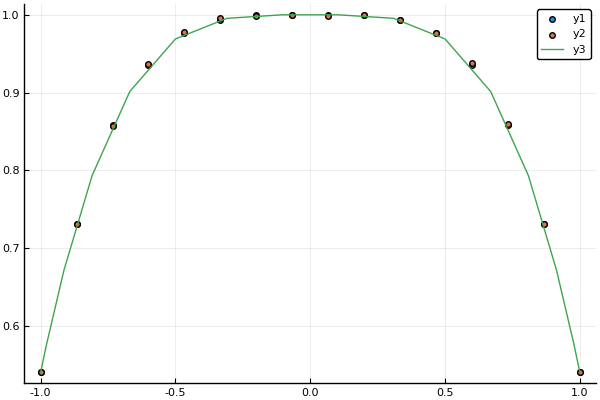

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [76]:
scatter(xe, interpolate( hermite, f, xe ))
scatter!(xe, interpolate( radial, f, xe ))
plot!(xk, f)

In [29]:
using IterTools

In [33]:
for k, v in product([:Hermite, :Radial],[:Uniform, :Chebyshev])
    println(k, v)
end

LoadError: syntax: invalid iteration specification

32-element Array{Float64,1}:
 0.54030230586814  
 0.6408970161773455
 0.7258102410433283
 0.7958633344738472
 0.8522796739163705
 0.8965416349514189
 0.9302692145972262
 0.9551209764487195
 0.9727162883451472
 0.9845767075724988
 0.99208373838787  
 0.9964499363706495
 0.9987003653073915
 ⋮                 
 0.9964499363706478
 0.9920837383878681
 0.984576707572498 
 0.9727162883451476
 0.95512097644872  
 0.9302692145972272
 0.896541634951419 
 0.8522796739163696
 0.7958633344738454
 0.7258102410433296
 0.6408970161773515
 0.540302305868137 